In [84]:
import yaml

In [85]:
# load menu
with open("mnt/city-directories/01-user-input/menu.yml", 'r') as f:
    menu = yaml.safe_load(f)

In [116]:
if menu['toolbox']:
    import os
    import glob
    import math
    import geopandas as gpd
    import pandas as pd
    import numpy as np
    import pint
    from pathlib import Path
    import matplotlib.pyplot as plt
    import rasterio
    from rasterio.warp import calculate_default_transform, reproject, Resampling
    from rasterio.plot import show
    from rasterstats import zonal_stats
    from osgeo import gdal, gdalconst
    from scipy.ndimage import generic_filter
    from shapely.geometry import LineString
    from shapely.ops import linemerge, unary_union
    import fiona
    import osmnx as ox
    from shapely.geometry import LineString, mapping
    from skimage import measure
    from shapely.ops import unary_union
    from rasterstats import zonal_stats
    from affine import Affine
    from rasterio.features import geometry_mask
    import fiona
    from rasterio.crs import CRS
    import warnings
    from rasterio.merge import merge 
    from rasterio.transform import from_bounds
    import csv
    from shapely.geometry import LineString, MultiPoint
    from shapely.ops import split, snap
    from rasterio.mask import mask
    import rasterio.features

read AOI shapefile


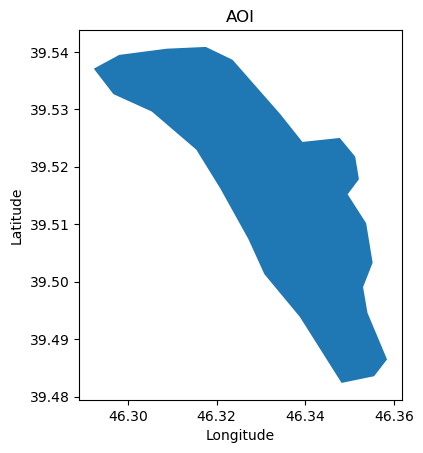

goris
armenia


In [87]:
# SET UP ##############################################

# load city inputs files, to be updated for each city scan
with open("city_inputs.yml", 'r') as f:
    city_inputs = yaml.safe_load(f)

city = city_inputs['city_name'].replace(' ', '_').lower()
country = city_inputs['country_name'].replace(' ', '_').lower()
# load global inputs, such as data sources that generally remain the same across scans

with open("global_inputs.yml", 'r') as f:
    global_inputs = yaml.safe_load(f)

# Read AOI shapefile --------
print('read AOI shapefile')
# transform the input shp to correct prj (epsg 4326)
aoi_file = gpd.read_file(city_inputs['AOI_path']).to_crs(epsg = 4326)
features = aoi_file.geometry

# Define output folder ---------
output_folder = Path('mnt/city-directories/02-process-output')
plot_folder = Path(output_folder/'plots')
pickle_folder = Path(output_folder/'pickles')

if not os.path.exists(output_folder):
    os.mkdir(output_folder)
    
fig, ax = plt.subplots()
features.plot(ax=ax)
plt.title('AOI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
print(city)
print(country)

In [88]:
#Slope
def get_slope():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
    
    if menu['elevation']:  
        elev_path = os.path.join(output_folder, city + '_elevation.tif')
        with rasterio.open(elev_path) as src:
            elev_data = src.read(1)  

            # Calculate the slope
            slope = np.gradient(elev_data)[1]

            
            plt.imshow(slope, cmap='viridis')
            plt.colorbar()
            plt.show()

            
            slope_path = os.path.join(output_folder, city + "_slope.tif")

            
            transform, width, height = calculate_default_transform(
                src.crs, 'EPSG:4326', src.width, src.height, *src.bounds)

            
            profile = src.profile
            profile.update({
                'crs': 'EPSG:4326',
                'transform': transform,
                'width': width,
                'height': height
            })

            
            with rasterio.open(slope_path, 'w', **profile) as dst:
                # Reproject the slope data
                reproject(
                    source=rasterio.band(src, 1),
                    destination=rasterio.band(dst, 1),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs='EPSG:4326',
                    resampling=Resampling.nearest)
                
                # Write the slope data to the output file
                dst.write(slope, 1)

            print("Slope calculation completed and saved to:", slope_path)

get_slope()

In [89]:
#merge pluvial 

def merge_pluvial_files():
    matching_files = glob.glob(os.path.join(output_folder, f"{city}_pluvial_2020_*.tif"))
    
    if matching_files:
        src_files_to_merge = [rasterio.open(pluvial_file) for pluvial_file in matching_files]
        
        merged_data, merged_transform = merge(src_files_to_merge)
        merged_crs = src_files_to_merge[0].crs
        
        output_file = os.path.join(output_folder, f"{city}_merged_pluvial_data.tif")
        with rasterio.open(output_file, 'w', driver='GTiff',
                           width=merged_data.shape[2], height=merged_data.shape[1],
                           count=1, dtype=merged_data.dtype,
                           crs=merged_crs, transform=merged_transform) as dst:
            dst.write(merged_data)

        print(f"Merged pluvial data saved as {output_file}")
        return output_file
    else:
        print("Error: No pluvial files found.")
        return None

merged_pluvial_file = merge_pluvial_files()


Merged pluvial data saved as mnt/city-directories/02-process-output/goris_merged_pluvial_data.tif


In [90]:
def merge_fluvial_files():
    matching_files = glob.glob(os.path.join(output_folder, f"{city}_fluvial_2020_*.tif"))
    
    if matching_files:
        src_files_to_merge = [rasterio.open(fluvial_file) for fluvial_file in matching_files]
        
        merged_data, merged_transform = merge(src_files_to_merge)
        merged_crs = src_files_to_merge[0].crs
        
        output_file = os.path.join(output_folder, f"{city}_merged_fluvial_data.tif")
        with rasterio.open(output_file, 'w', driver='GTiff',
                           width=merged_data.shape[2], height=merged_data.shape[1],
                           count=1, dtype=merged_data.dtype,
                           crs=merged_crs, transform=merged_transform) as dst:
            dst.write(merged_data)

        print(f"Merged fluvial data saved as {output_file}")
        return output_file
    else:
        print("Error: No fluvial files found.")
        return None

merged_fluvial_file = merge_fluvial_files()

Merged fluvial data saved as mnt/city-directories/02-process-output/goris_merged_fluvial_data.tif


In [91]:
#merge comb files and save a merged file  (everything with a value is 1, otherwise 0 )

In [92]:
#merge coastal files and save a merged file  (everything with a value is 1, otherwise 0 )

In [93]:
#resampling data
def resample_raster(input_raster, target_shape):
    # Resample raster to match the target shape
    data = input_raster.read(1, out_shape=target_shape, resampling=Resampling.nearest)
    return data

In [94]:
#pu_wsf - I am using the merged pluvial files, reprojecting and clipping both to the AOI, selecting the wsf pixel values that overlap with pu==1, 
#and then converting that to area
#goris does not match though:(
def get_pu_wsf():
    if menu.get('flood') and menu.get('wsf'):
        pu_path = os.path.join(output_folder, f"{city}_merged_pluvial_data.tif")
        wsf_path = os.path.join(output_folder, f"{city}_wsf_4326_reclass.tif")

        
        with rasterio.open(pu_path) as src_pluvial:
            pluvial_data, pluvial_transform = mask(src_pluvial, features, crop=True)
            pluvial_data = pluvial_data[0]  # Extract the clipped pluvial data
            pluvial_affine = pluvial_transform
            pluvial_resolution = abs(pluvial_transform[0] * pluvial_transform[4])  

        with rasterio.open(wsf_path) as src_wsf:
            wsf_data, wsf_transform = mask(src_wsf, features, crop=True)
            wsf_data = wsf_data[0]  
            wsf_affine = wsf_transform

            reprojected_wsf_data = np.zeros_like(pluvial_data)
            reproject(
                wsf_data,
                reprojected_wsf_data,
                src_transform=wsf_affine,
                src_crs=src_wsf.crs,
                dst_transform=pluvial_affine,
                dst_crs=src_pluvial.crs,
                resampling=Resampling.nearest
            )

        # Ensure both arrays have the same shape
        min_height = min(pluvial_data.shape[0], reprojected_wsf_data.shape[0])
        min_width = min(pluvial_data.shape[1], reprojected_wsf_data.shape[1])
        pluvial_data = pluvial_data[:min_height, :min_width]
        reprojected_wsf_data = reprojected_wsf_data[:min_height, :min_width]

        pixel_areas = {}

        # Loop through each unique pixel value in the WSF data
        unique_values = np.unique(reprojected_wsf_data)
        for value in unique_values:
            # Only consider the pixels where pluvial data equals 1
            masked_wsf_data = np.where(pluvial_data == 1, reprojected_wsf_data, 0)

            count = np.sum(masked_wsf_data == value)

            # Calculate the area based on the count of pixels and pixel resolution
            area = count * pluvial_resolution

            # Store the area in the dictionary
            pixel_areas[value] = area

        return pixel_areas
    else:
        print("Flood or WSF menu not selected.")
        return None


pu_wsf_areas = get_pu_wsf()
if pu_wsf_areas is not None:

    for value, area in pu_wsf_areas.items():
        print(f"Area corresponding to wsf value {value}: {area} square units")

    csv_file = os.path.join(output_folder, f"{city}_pu_wsf_area.csv")
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Pixel Value', 'Area (square units)'])
        for value, area in pu_wsf_areas.items():
            writer.writerow([value, area])
    print(f"WSF_Pu_Area saved to {csv_file}")


Area corresponding to wsf value 0: 0.0036725308641976026 square units
Area corresponding to wsf value 1: 9.837962962963156e-05 square units
Area corresponding to wsf value 2: 2.2608024691358466e-05 square units
Area corresponding to wsf value 3: 1.6280864197531184e-05 square units
Area corresponding to wsf value 4: 6.288580246913703e-05 square units
Area corresponding to wsf value 255: 1.844135802469172e-05 square units
WSF_Pu_Area saved to mnt/city-directories/02-process-output/goris_pu_wsf_area.csv


In [95]:
def get_fluvial_wsf():
    if menu.get('flood') and menu.get('wsf'):
        fluvial_path = os.path.join(output_folder, f"{city}_merged_fluvial_data.tif")
        wsf_path = os.path.join(output_folder, f"{city}_wsf_4326_reclass.tif")

        
        with rasterio.open(fluvial_path) as src_fluvial:
            fluvial_data, fluvial_transform = mask(src_fluvial, features, crop=True)
            fluvial_data = fluvial_data[0]  # Extract the clipped fluvial data
            fluvial_affine = fluvial_transform
            fluvial_resolution = abs(fluvial_transform[0] * fluvial_transform[4])  

        with rasterio.open(wsf_path) as src_wsf:
            wsf_data, wsf_transform = mask(src_wsf, features, crop=True)
            wsf_data = wsf_data[0]  
            wsf_affine = wsf_transform

            reprojected_wsf_data = np.zeros_like(fluvial_data)
            reproject(
                wsf_data,
                reprojected_wsf_data,
                src_transform=wsf_affine,
                src_crs=src_wsf.crs,
                dst_transform=fluvial_affine,
                dst_crs=src_fluvial.crs,
                resampling=Resampling.nearest
            )

        # Ensure both arrays have the same shape
        min_height = min(fluvial_data.shape[0], reprojected_wsf_data.shape[0])
        min_width = min(fluvial_data.shape[1], reprojected_wsf_data.shape[1])
        fluvial_data = fluvial_data[:min_height, :min_width]
        reprojected_wsf_data = reprojected_wsf_data[:min_height, :min_width]

        pixel_areas = {}

        # Loop through each unique pixel value in the wsf data
        unique_values = np.unique(reprojected_wsf_data)
        for value in unique_values:
            # Only consider the pixels where fluvial data equals 1
            masked_wsf_data = np.where(fluvial_data == 1, reprojected_wsf_data, 0)

            count = np.sum(masked_wsf_data == value)

            # Calculate the area based on the count of pixels and pixel resolution
            area = count * fluvial_resolution

            # Store the area in the dictionary
            pixel_areas[value] = area

        return pixel_areas
    else:
        print("Fluvial or WSF menu not selected.")
        return None


fluvial_wsf_areas = get_fluvial_wsf()
if fluvial_wsf_areas is not None:

    for value, area in fluvial_wsf_areas.items():
        print(f"Area corresponding to wsf value {value}: {area} square units")

    csv_file = os.path.join(output_folder, f"{city}_fu_wsf_area.csv")
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Pixel Value', 'Area (square units)'])
        for value, area in fluvial_wsf_areas.items():
            writer.writerow([value, area])
    print(f"WSF_Fluvial_Area saved to {csv_file}")


Area corresponding to wsf value 0: 0.0038911265432099527 square units
Area corresponding to wsf value 1: 0.0 square units
Area corresponding to wsf value 2: 0.0 square units
Area corresponding to wsf value 3: 0.0 square units
Area corresponding to wsf value 4: 0.0 square units
Area corresponding to wsf value 255: 0.0 square units
WSF_Fluvial_Area saved to mnt/city-directories/02-process-output/goris_fu_wsf_area.csv


In [96]:
#Do the same for comb files

In [97]:
#Do the same for coastal files 

In [98]:
#densely populated areas are those >pop_mean
#where >pop_mean intersects with merged_pluvial_data, we count the number of pixels
def get_pu_pop():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
        
    if menu.get('flood') and menu.get('population'):
          
        pu_path = os.path.join(output_folder, f"{city}_merged_pluvial_data.tif")
        try:
            with rasterio.open(pu_path) as pu_src:
                merged_pluvial_data = pu_src.read(1)
                merged_pluvial_data_transform = pu_src.transform
                merged_pluvial_data_shape = merged_pluvial_data.shape
        except Exception as e:
            print(f"Error opening merged pluvial data raster: {e}")
            return

        pop_path = os.path.join(output_folder, f"{city}_population.tif")
        try:
            with rasterio.open(pop_path) as pop_src:
                pop_data = pop_src.read(1)
                pop_transform = pop_src.transform
                pop_shape = pop_data.shape

                # Resample population raster to match the shape of merged pluvial data
                pop_data_resampled = resample_raster(pop_src, merged_pluvial_data_shape)

        except Exception as e:
            print(f"Error opening or resampling population raster: {e}")
            return

        pop_data_clipped = np.clip(pop_data_resampled, 0, None)
        pop_mean = pop_data_clipped.mean()

        total_count = np.sum((merged_pluvial_data == 1) & (pop_data_clipped > pop_mean))
        total_pixels = merged_pluvial_data.size

        percentage = (total_count / total_pixels) * 100
        print(f" {percentage:.2f}% of densely populated areas are located within the riverine flood risk zone with a minimum depth of 15 cm ")


        
        csv_path = os.path.join(output_folder, 'pu_pop_area.csv')
        df = pd.DataFrame({'File Name': 'Combined', 'Percentage': percentage}, index=[0])
        df.to_csv(csv_path, index=False)
        print(f"Result saved to {csv_path}")
    else:
        print("Flood or population menu not selected.")

get_pu_pop()


 0.81% of densely populated areas are located within the riverine flood risk zone with a minimum depth of 15 cm 
Result saved to mnt/city-directories/02-process-output/pu_pop_area.csv


In [99]:
#densely populated areas are those >pop_mean
#where >pop_mean intersects with merged_fluvial_data, we count the number of pixels
def get_fu_pop():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
        
    if menu.get('flood') and menu.get('population'):  
        fu_path = os.path.join(output_folder, f"{city}_merged_fluvial_data.tif")
        try:
            with rasterio.open(fu_path) as fu_src:
                merged_fluvial_data = fu_src.read(1)
                merged_fluvial_data_transform = fu_src.transform
                merged_fluvial_data_shape = merged_fluvial_data.shape
        except Exception as e:
            print(f"Error opening merged fluvial data raster: {e}")
            return

        pop_path = os.path.join(output_folder, f"{city}_population.tif")
        try:
            with rasterio.open(pop_path) as pop_src:
                pop_data = pop_src.read(1)
                pop_transform = pop_src.transform
                pop_shape = pop_data.shape

                # Resample population raster to match the shape of merged fluvial data
                pop_data_resampled = resample_raster(pop_src, merged_fluvial_data_shape)

        except Exception as e:
            print(f"Error opening or resampling population raster: {e}")
            return

        pop_data_clipped = np.clip(pop_data_resampled, 0, None)
        pop_mean = pop_data_clipped.mean()

        total_count = np.sum((merged_fluvial_data == 1) & (pop_data_clipped > pop_mean))
        total_pixels = merged_fluvial_data.size

        percentage = (total_count / total_pixels) * 100
        print(f" {percentage:.2f}% of densely populated areas are located within the rainwater flood risk zone with a minimum depth of 15 cm ")

        
        csv_path = os.path.join(output_folder, 'fu_pop_area.csv')
        df = pd.DataFrame({'File Name': 'Combined', 'Percentage': percentage}, index=[0])
        df.to_csv(csv_path, index=False)
        print(f"Result saved to {csv_path}")
    else:
        print("Flood or population menu not selected.")

get_fu_pop()


 0.08% of densely populated areas are located within the rainwater flood risk zone with a minimum depth of 15 cm 
Result saved to mnt/city-directories/02-process-output/fu_pop_area.csv


In [100]:
# Pu Amenities

def get_pu_am():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
        
    if menu.get('flood') and menu.get('amenities'):  
        pu_path = os.path.join(output_folder, f"{city}_merged_pluvial_data.tif")
        try:
            with rasterio.open(pu_path) as pu_src:
                merged_pluvial_data = pu_src.read(1)
                merged_pluvial_data_transform = pu_src.transform
                merged_pluvial_data_shape = merged_pluvial_data.shape
        except Exception as e:
            print(f"Error opening merged pluvial data raster: {e}")
            return

        
        stats_list = []
        for category in ['health', 'police', 'fire','schools']:
            shapefile_path = os.path.join(output_folder, f"{city}_osm_{category}", f"{city}_osm_{category}.shp")
            try:
                amenities = gpd.read_file(shapefile_path)

                with rasterio.open(pu_path) as src:
                    affine = src.transform

                stats = zonal_stats(amenities, merged_pluvial_data, nodata=0, affine=affine, stats=["count"], geojson_out=True)

                count_overlap = sum([feature["properties"]["count"] for feature in stats])
                total_count = len(amenities)
                percentage = (count_overlap / total_count) * 100

                stats_list.append({'Category': category, 'Overlap': count_overlap, 'Total': total_count, 'Percentage': percentage})

                print(f"{count_overlap} of {total_count} ({percentage:.2f}%) {category} are located in a riverine flood risk zone with a minimum depth of 15 cm.")

            except Exception as e:
                if category == 'fire':
                    print("Fire stations do not exist")
                else:
                    print(f"Error processing {category} shapefile: {e}")
        
        df = pd.DataFrame(stats_list)
        
        
        excel_file = os.path.join(output_folder, 'pu_osmpt.xlsx')
        df.to_excel(excel_file, index=False)
        print(f"Statistics saved to {excel_file}")

# Suppress warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

get_pu_am()


0 of 3 (0.00%) health are located in a riverine flood risk zone with a minimum depth of 15 cm.
2 of 3 (66.67%) police are located in a riverine flood risk zone with a minimum depth of 15 cm.
Fire stations do not exist
6 of 10 (60.00%) schools are located in a riverine flood risk zone with a minimum depth of 15 cm.
Statistics saved to mnt/city-directories/02-process-output/pu_osmpt.xlsx


In [101]:
import yaml
import rasterio
import os
import geopandas as gpd
from rasterstats import zonal_stats

def get_pu_roads(output_folder, city, features):
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)

    # File paths
    pu_path = os.path.join(output_folder, f"{city}_merged_pluvial_data.tif")
    roads_path = os.path.join('output/goris_edges.shp')

    # Read pluvial data
    try:
        with rasterio.open(pu_path) as pu_src:
            merged_pluvial_data = pu_src.read(1)
            transform = pu_src.transform  # Get the affine transformation
            nodata_value = pu_src.nodata  # Get the nodata value
    except Exception as e:
        print(f"Error opening merged pluvial data raster: {e}")
        return

    # Read roads data
    try:
        roads = gpd.read_file(roads_path)
    except Exception as e:
        print(f"Error reading road network shapefile: {e}")
        return

    # Perform zonal stats to get counts of pluvial pixels intersecting highways
    try:
        stats = zonal_stats(roads.geometry, merged_pluvial_data, affine=transform, nodata=nodata_value, stats="count")
    except Exception as e:
        print(f"Error calculating zonal statistics: {e}")
        return

    print(f"Stats: {stats}")

    # Filter and clip highways based on pluvial condition
    try:
        highways_flooded = roads[stats[0]['count'] > 0]
        print(f"Highways flooded: {highways_flooded}")
        highways_flooded['clipped_length'] = highways_flooded.geometry.intersection(features.geometry).length
        total_length_flooded_highways = highways_flooded['clipped_length'].sum()
    except Exception as e:
        print(f"Error filtering and clipping highways based on pluvial condition: {e}")
        return

    print(f"Highways flooded: {highways_flooded}")

    # Calculate total length of highways
    total_length_all_highways = roads.geometry.length.sum()

    # Calculate the percentage of flooded highways
    percent_flooded_highways = (total_length_flooded_highways / total_length_all_highways) * 100

    print(f"Percentage of highways flooded due to pluvial conditions: {percent_flooded_highways:.2f}%")
get_pu_roads(output_folder, city, features)


Stats: [{'count': 8}, {'count': 20}, {'count': 8}, {'count': 2}, {'count': 14}, {'count': 1}, {'count': 16}, {'count': 6}, {'count': 4}, {'count': 13}, {'count': 4}, {'count': 5}, {'count': 7}, {'count': 8}, {'count': 10}, {'count': 5}, {'count': 6}, {'count': 6}, {'count': 6}, {'count': 10}, {'count': 25}, {'count': 11}, {'count': 3}, {'count': 2}, {'count': 6}, {'count': 5}, {'count': 5}, {'count': 5}, {'count': 6}, {'count': 9}, {'count': 3}, {'count': 18}, {'count': 6}, {'count': 9}, {'count': 24}, {'count': 3}, {'count': 6}, {'count': 4}, {'count': 5}, {'count': 7}, {'count': 4}, {'count': 5}, {'count': 5}, {'count': 8}, {'count': 3}, {'count': 6}, {'count': 4}, {'count': 7}, {'count': 5}, {'count': 6}, {'count': 18}, {'count': 6}, {'count': 5}, {'count': 7}, {'count': 5}, {'count': 5}, {'count': 5}, {'count': 4}, {'count': 6}, {'count': 6}, {'count': 5}, {'count': 7}, {'count': 6}, {'count': 6}, {'count': 5}, {'count': 5}, {'count': 8}, {'count': 7}, {'count': 6}, {'count': 5}, {

/var/folders/tb/lt6mv9zn47973s97jtlwv_b40000gn/T/ipykernel_29418/1028202833.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['length_m'] = gdf['geometry'].length


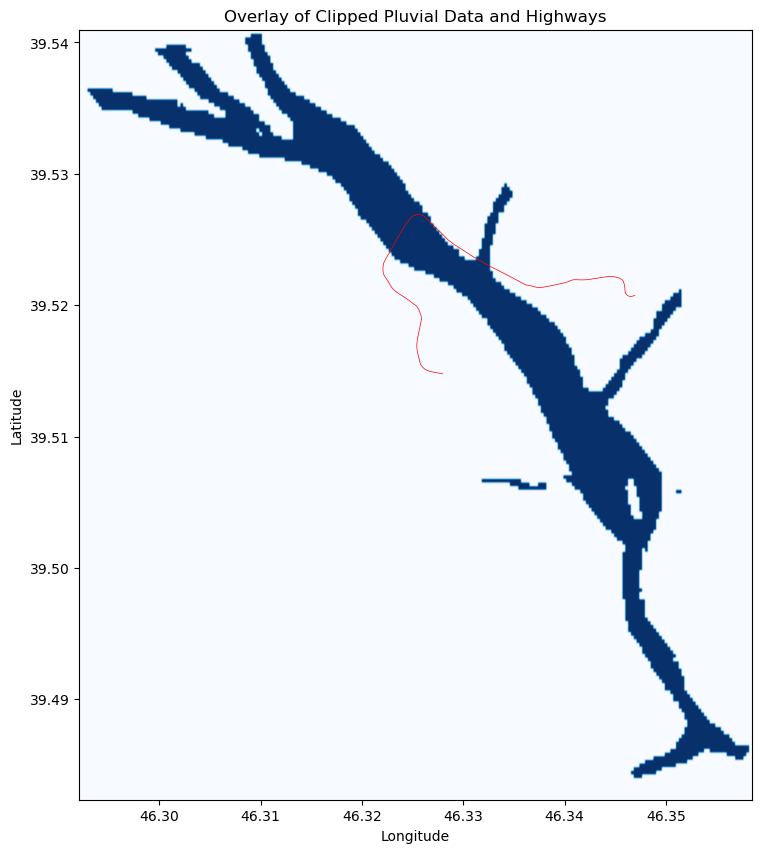

In [117]:
def get_pu_roads(output_folder, city, menu, features):
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
        
    if menu.get('flood') and menu.get('amenities'):  
        pu_path = os.path.join(output_folder, f"{city}_merged_pluvial_data.tif")
        try:
            pu_src = rasterio.open(pu_path)
            merged_pluvial_data, _ = pu_src.read(1), pu_src.transform
        except Exception as e:
            print(f"Error opening merged pluvial data raster: {e}")
            return
        
        roads_path = r'output/goris_edges.shp'
        try:
            roads = gpd.read_file(roads_path)
            roads_primary = roads[roads['highway'] == 'primary']  # Filter primary roads
            gdf = gpd.clip(roads_primary, features.geometry)
            gdf['length_m'] = gdf['geometry'].length
        except Exception as e:
            print(f"Error reading road network shapefile: {e}")
            return

        # Save a new clipped pluvial data raster file
        clipped_pu_path = os.path.join(output_folder, f"{city}_clipped_pluvial_data.tif")
        try:
            clipped_pluvial, pluvial_transform = mask(pu_src, features.geometry, crop=True)
            clipped_meta = pu_src.meta.copy()
            clipped_meta.update({"driver": "GTiff",
                                 "height": clipped_pluvial.shape[1],
                                 "width": clipped_pluvial.shape[2],
                                 "transform": pluvial_transform})
            with rasterio.open(clipped_pu_path, 'w', **clipped_meta) as clipped_pu_dst:
                clipped_pu_dst.write(clipped_pluvial)
        except Exception as e:
            print(f"Error saving clipped pluvial data raster: {e}")
            return

        clipped_pu_src = rasterio.open(clipped_pu_path)

        # Clip the highways shapefile to the extent of edges
        try:
            clipped_highways = gpd.clip(roads_primary, features.geometry)
        except Exception as e:
            print(f"Error clipping highways shapefile to the extent of edges: {e}")
            return

        # Plotting the clipped pluvial data and highways
        fig, ax = plt.subplots(figsize=(10, 10))
        show(clipped_pluvial, ax=ax, transform=pluvial_transform, cmap='Blues')
        clipped_highways.plot(ax=ax, color='red', linewidth=0.5)
        plt.title('Overlay of Clipped Pluvial Data and Highways')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()

# Call the function with appropriate arguments
get_pu_roads(output_folder, city, menu, features)


In [387]:
# Fu Amenities

def get_fu_am():
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
        
    if menu.get('flood') and menu.get('amenities'):  
        fu_path = os.path.join(output_folder, f"{city}_merged_fluvial_data.tif")
        try:
            with rasterio.open(fu_path) as fu_src:
                merged_fluvial_data = fu_src.read(1)
                merged_fluvial_transform = fu_src.transform
                merged_fluvial_shape = merged_fluvial_data.shape
        except Exception as e:
            print(f"Error opening merged fluvial data raster: {e}")
            return

        
        stats_list = []
        for category in ['health', 'police', 'fire']:
            shapefile_path = os.path.join(output_folder, f"{city}_osm_{category}", f"{city}_osm_{category}.shp")
            try:
                amenities = gpd.read_file(shapefile_path)

                with rasterio.open(fu_path) as src:
                    affine = src.transform

                stats = zonal_stats(amenities, merged_fluvial_data, nodata=0, affine=affine, stats=["count"], geojson_out=True)

                count_overlap = sum([feature["properties"]["count"] for feature in stats])
                total_count = len(amenities)
                percentage = (count_overlap / total_count) * 100

                stats_list.append({'Category': category, 'Overlap': count_overlap, 'Total': total_count, 'Percentage': percentage})

                print(f"{count_overlap} of {total_count} ({percentage:.2f}%) {category} are located in a riverine flood risk zone with a minimum depth of 15 cm.")

            except Exception as e:
                if category == 'fire':
                    print("Fire stations do not exist")
                else:
                    print(f"Error processing {category} shapefile: {e}")

        # Process roads separately
        roads_path = os.path.join(output_folder, f"{city}_road_network", f"{city}_edges.shp")
        try:
            roads = gpd.read_file(roads_path)
            roads_clip = gpd.clip(roads, features.geometry)
            
            
            total_length = roads_clip.length.sum()
            
            # Calculate length of roads overlapping with fluvial == 1
            roads_overlap = roads_clip.geometry.intersection(features.geometry)
            overlap_length = roads_overlap.length.sum()
            
            
            percentage = (overlap_length / total_length) * 100

            print(f"{overlap_length} of {total_length:.2f} ({percentage:.2f}%) of roads are located in a riverine flood risk zone with a minimum depth of 15 cm.")

        except Exception as e:
            print(f"Error processing roads shapefile: {e}")
        
        df = pd.DataFrame(stats_list)
        
        
        excel_file = os.path.join(output_folder, 'fu_osmpt.xlsx')
        df.to_excel(excel_file, index=False)
        print(f"Statistics saved to {excel_file}")

# Suppress warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

get_fu_am()


0 of 3 (0.00%) health are located in a riverine flood risk zone with a minimum depth of 15 cm.
0 of 3 (0.00%) police are located in a riverine flood risk zone with a minimum depth of 15 cm.
Fire stations do not exist
0.002143343723870679 of 0.90 (0.24%) of roads are located in a riverine flood risk zone with a minimum depth of 15 cm.
Statistics saved to mnt/city-directories/02-process-output/fu_osmpt.xlsx


/var/folders/tb/lt6mv9zn47973s97jtlwv_b40000gn/T/ipykernel_10595/1840729694.py:51: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  total_length = roads_clip.length.sum()
/Users/ipshitakarmakar/mambaforge/envs/geo/lib/python3.11/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/var/folders/tb/lt6mv9zn47973s97jtlwv_b40000gn/T/ipykernel_10595/1840729694.py:55: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap_length = roads_overlap.length.sum()


/var/folders/tb/lt6mv9zn47973s97jtlwv_b40000gn/T/ipykernel_29418/1980048619.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['length_m'] = gdf['geometry'].length


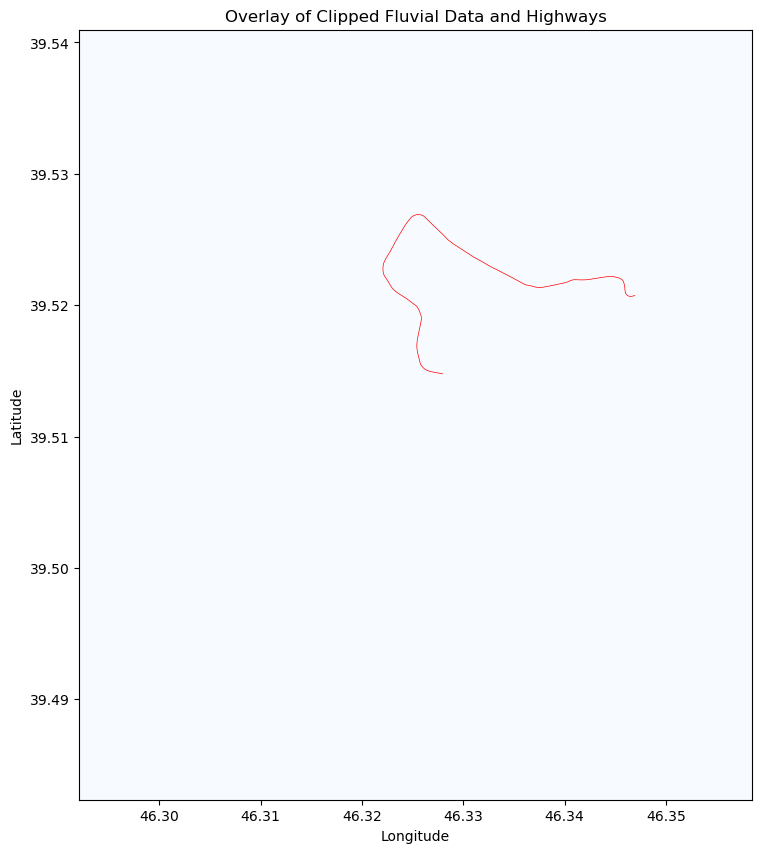

In [112]:
def get_fu_roads(output_folder, city, menu, features):
    with open("global_inputs.yml", 'r') as f:
        global_inputs = yaml.safe_load(f)
        
    if menu.get('flood') and menu.get('amenities'):  
        fu_path = os.path.join(output_folder, f"{city}_merged_fluvial_data.tif")
        try:
            fu_src = rasterio.open(fu_path)
            merged_fluvial_data, _ = fu_src.read(1), fu_src.transform
        except Exception as e:
            print(f"Error opening merged fluvial data raster: {e}")
            return
        
        roads_path = r'output/goris_edges.shp'
        try:
            roads = gpd.read_file(roads_path)
            roads_primary = roads[roads['highway'] == 'primary']  # Filter primary roads
            gdf = gpd.clip(roads_primary, features.geometry)
            gdf['length_m'] = gdf['geometry'].length
        except Exception as e:
            print(f"Error reading road network shapefile: {e}")
            return

        # Save a new clipped fluvial data raster file
        clipped_fu_path = os.path.join(output_folder, f"{city}_clipped_fluvial_data.tif")
        try:
            clipped_fluvial, fluvial_transform = mask(fu_src, features.geometry, crop=True)
            clipped_meta = fu_src.meta.copy()
            clipped_meta.update({"driver": "GTiff",
                                 "height": clipped_fluvial.shape[1],
                                 "width": clipped_fluvial.shape[2],
                                 "transform": fluvial_transform})
            with rasterio.open(clipped_fu_path, 'w', **clipped_meta) as clipped_fu_dst:
                clipped_fu_dst.write(clipped_fluvial)
        except Exception as e:
            print(f"Error saving clipped fluvial data raster: {e}")
            return

        clipped_fu_src = rasterio.open(clipped_fu_path)

        # Clip the highways shapefile to the extent of edges
        try:
            clipped_highways = gpd.clip(roads_primary, features.geometry)
        except Exception as e:
            print(f"Error clipping highways shapefile to the extent of edges: {e}")
            return

        # Plotting the clipped fluvial data and highways
        fig, ax = plt.subplots(figsize=(10, 10))
        show(clipped_fluvial, ax=ax, transform=fluvial_transform, cmap='Blues')
        clipped_highways.plot(ax=ax, color='red', linewidth=0.5)
        plt.title('Overlay of Clipped Fluvial Data and Highways')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()

# Call the function with appropriate arguments
get_fu_roads(output_folder, city, menu, features)


In [ ]:
#Comb WSF

In [ ]:
#Comb Population

In [ ]:
#Comb Amenities

In [ ]:
#Coastal WSF

In [ ]:
#Coastal Population

In [ ]:
#Coastal Amenities